In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.stats import linregress
os.chdir('../util')
from util import exclude_outliers
from util import iqr_exclude

In [2]:
# Mt. Sinai data location
file_dir = '/data/Ali/RadDBS-QSM/src/csv'

In [3]:
# Load patient data
os.chdir(file_dir)
df = pd.read_csv('VRS_QSM patient UPDRS post-scoring - Copy.csv')

In [4]:
# Display original dataframe
df

,Anonymous ID,Unnamed: 1,DBS Location,Side,Apathy,SAS,Unnamed: 6,Unnamed: 7,Unnamed: 8,Anxiety,...,Unnamed: 22,MDS-UPDRS: Part III (Motor),Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Pre-Op MRI Brain,Post-Op MRI Brain,Notes
0,NaN,NaN,NaN,NaN,NaN,Pre-DBS ON,Pre-DBS OFF,Post-DBS ON,Post-DBS OFF,NaN,...,Post-DBS,"Pre-DBS, On Meds","Pre-DBS, Off Meds","Post-DBS, Off Meds, Stim Off","Post-DBS, OnMeds, Stim Off","Post-DBS, Off Meds, Stim On","Post-DBS, On Meds, Stim On",NaN,NaN,NaN
1,1.0,NaN,STN,Bilateral,Y,8,13,21,NaN,Y,...,NaN,54,65,30,NaN,11,NaN,3/8/2021,NaN,NaN
2,2.0,NaN,STN,Bilateral,N,2,2,3,NaN,N,...,NaN,7,22,NaN,NaN,2,NaN,7/19/2021,NaN,NaN
3,3.0,NaN,STN,Bilateral,Y,12,9,19,NaN,Y,...,NaN,13,45,NaN,NaN,20,NaN,7/22/2019,NaN,NaN
4,4.0,NaN,STN,Bilateral,Y,17,20,13,NaN,Y,...,NaN,16,35,12,NaN,NaN,5,9/28/2020,NaN,NaN
5,5.0,NaN,STN,Bilateral,Y,11,21,13,23,Y,...,NaN,12,48,NaN,NaN,NaN,22,3/2/2020,NaN,Episodic mood disorder
6,6.0,NaN,STN,Bilateral,Y,22,12,14,NaN,Y,...,NaN,32,63,17,NaN,3,NaN,2/8/2021,NaN,NaN
7,7.0,NaN,STN,Bilateral,N,2,3,11,NaN,N,...,NaN,8,31,NaN,NaN,NaN,5,7/27/2020,NaN,NaN
8,8.0,NaN,STN,Bilateral,Y,5,27,12,NaN,N,...,NaN,8,61,NaN,NaN,NaN,6,9/14/2020,NaN,NaN
9,9.0,NaN,STN,Bilateral,Y,13,22,23,NaN,Y,...,NaN,21,63,NaN,NaN,7,NaN,10/5/2020,NaN,NaN


In [5]:
# Make a copy
dfd = df.copy()

In [6]:
# Drop blank columns
for (columnName, columnData) in dfd.iteritems():
    if columnData.isnull().all():
        print('Dropping NaN column at',columnName)
        dfd.drop(columnName,axis=1,inplace=True)

Dropping NaN column at Unnamed: 1
Dropping NaN column at Post-Op MRI Brain


In [7]:
# Add relevant column names from headers
df_headers = []
for (columnName, columnData) in dfd.iteritems():
    if 'Unnamed' not in columnName:
        df_headers.append(columnName)
    else:
        print('Renaming',columnName,'as',df_headers[-1]+' '+str(dfd.iloc[0, df.columns.get_loc(columnName)-1]))
        dfd.rename(columns={columnName:df_headers[-1]+' '+str(dfd.iloc[0, df.columns.get_loc(columnName)-1])},inplace=True)

Renaming Unnamed: 6 as SAS Pre-DBS OFF
Renaming Unnamed: 7 as SAS Post-DBS ON
Renaming Unnamed: 8 as SAS Post-DBS OFF
Renaming Unnamed: 11 as BAI Pre-DBS OFF
Renaming Unnamed: 12 as BAI Post-DBS ON
Renaming Unnamed: 13 as BAI Post-DBS OFF
Renaming Unnamed: 16 as BDI-II Pre-DBS OFF
Renaming Unnamed: 17 as BDI-II Post-DBS ON
Renaming Unnamed: 18 as BDI-II Post-DBS OFF
Renaming Unnamed: 20 as MDS-UPDRS: Part I (Mood and Cognitive) Anxiety
Renaming Unnamed: 21 as MDS-UPDRS: Part I (Mood and Cognitive) Apathy
Renaming Unnamed: 22 as MDS-UPDRS: Part I (Mood and Cognitive) Post-DBS
Renaming Unnamed: 24 as MDS-UPDRS: Part III (Motor) Pre-DBS, Off Meds
Renaming Unnamed: 25 as MDS-UPDRS: Part III (Motor) Post-DBS, Off Meds, Stim Off
Renaming Unnamed: 26 as MDS-UPDRS: Part III (Motor) Post-DBS, OnMeds, Stim Off
Renaming Unnamed: 27 as MDS-UPDRS: Part III (Motor) Post-DBS, Off Meds, Stim On
Renaming Unnamed: 28 as MDS-UPDRS: Part III (Motor) Post-DBS, On Meds, Stim On


In [8]:
# Make a copy for motor symptoms
motor_df = dfd.copy()
# Drop non-motor (III) columns
for (columnName, columnData) in dfd.iteritems():
    if 'MDS-UPDRS: Part III' in columnName:
        next
    elif 'Anonymous ID' in columnName:
        motor_df.iloc[0,0] = 'Anonymous ID'
    else:
        motor_df.drop(columnName,axis=1,inplace=True)

In [9]:
# Rename columns with specific metrics
motor_df.columns = motor_df.iloc[0]
motor_df = motor_df.tail(-1)

In [10]:
motor_df

,Anonymous ID,"Pre-DBS, On Meds","Pre-DBS, Off Meds","Post-DBS, Off Meds, Stim Off","Post-DBS, OnMeds, Stim Off","Post-DBS, Off Meds, Stim On","Post-DBS, On Meds, Stim On"
1,1.0,54,65,30,NaN,11,NaN
2,2.0,7,22,NaN,NaN,2,NaN
3,3.0,13,45,NaN,NaN,20,NaN
4,4.0,16,35,12,NaN,NaN,5
5,5.0,12,48,NaN,NaN,NaN,22
6,6.0,32,63,17,NaN,3,NaN
7,7.0,8,31,NaN,NaN,NaN,5
8,8.0,8,61,NaN,NaN,NaN,6
9,9.0,21,63,NaN,NaN,7,NaN
10,10.0,14,27,37,NaN,11,6


In [11]:
# Convert columns to numerical arrays
df_post_dbs_off_meds_on_stim = motor_df['Post-DBS, Off Meds, Stim On'].to_numpy().astype('float')
df_post_dbs_off_meds_off_stim = motor_df['Post-DBS, Off Meds, Stim Off'].to_numpy().astype('float')
df_pre_dbs_off_meds = motor_df['Pre-DBS, Off Meds'].to_numpy().astype('float')
df_pre_dbs_on_meds = motor_df['Pre-DBS, On Meds'].to_numpy().astype('float')

In [12]:
# Find numerical entries only
cases = np.where(~np.isnan(df_post_dbs_off_meds_on_stim))

From Zhao et. al and Lin et. al, define medication responsivness as:

$$ \rho_{med} = \frac{u_{pre,\,off\,med}-u_{pre,\,on\,med}}{u_{pre,\,off\,med}}$$

Where $\rho_{med}$ is `pre_dbs_meds_improvement`, $u_{pre,\,off\,med}$ is `df_pre_dbs_off_meds` and $u_{pre,\,on\,med}$ is `df_pre_dbs_on_meds`

In [13]:
pre_dbs_meds_improvement = (df_pre_dbs_off_meds[cases]-df_pre_dbs_on_meds[cases])/df_pre_dbs_off_meds[cases]

Both Zhao et. al and Liu et. al define DBS responsivness as:

$$ \rho_{stim} = \frac{u_{pre,\,off\,med}-u_{post,\,stim\,on,\,off-med}}{u_{pre,\,off\,med}}$$

Where $\rho_{stim}$ is `dbs_off_meds_improvement`, $u_{pre,\,off\,med}$ is `df_pre_dbs_off_meds` and $u_{post,\,on\,stim,\,off\,med}$ is `df_post_dbs_off_meds_on_stim`

In [14]:
dbs_off_meds_improvement = (df_pre_dbs_off_meds[cases]-df_post_dbs_off_meds_on_stim[cases])/df_pre_dbs_off_meds[cases]

75th percentile at 0.8725038402457758
25th percentile at 0.6681034482758621
Interquartile range of 0.20440039196991366
Upper bound of 1.0769042322156894
Lower bound of 0.46370305630594844
Excluded 14 outliers


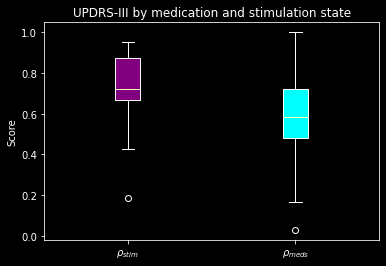

In [15]:
[fig, ax] = plt.subplots()
x_m = iqr_exclude(dbs_off_meds_improvement)
label = [r'$\rho_{stim}$',r'$\rho_{meds}$']
bplots = ax.boxplot([dbs_off_meds_improvement,pre_dbs_meds_improvement],labels=label,patch_artist=True,capprops=dict(color='white'),whiskerprops=dict(color='white'),flierprops=dict(color='white', markeredgecolor='white'))
# fill with colors
colors = ['purple', 'cyan', 'green','orange']
for bplot in bplots:
    for patch, color in zip(bplots['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('white')
        
ax.set_ylabel('Score')
plt.title('UPDRS-III by medication and stimulation state')
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20,20)
plt.show()


75th percentile at 0.8725038402457758
25th percentile at 0.6681034482758621
Interquartile range of 0.20440039196991366
Upper bound of 1.0769042322156894
Lower bound of 0.46370305630594844
Excluded 14 outliers


/data/Ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


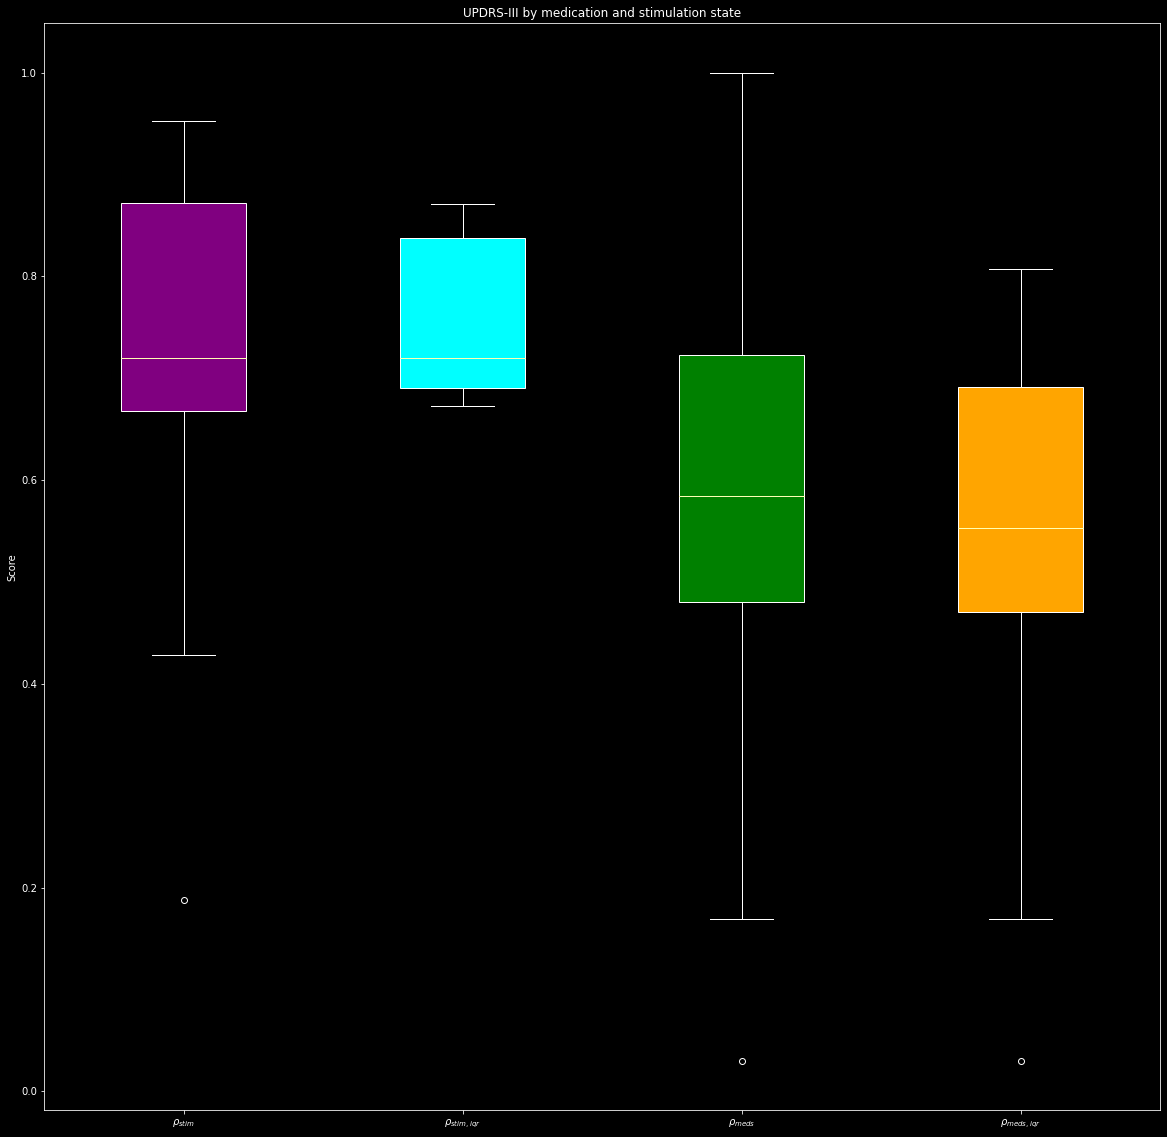

In [16]:
[fig, ax] = plt.subplots()
x_m = iqr_exclude(dbs_off_meds_improvement)
label = [r'$\rho_{stim}$',r'$\rho_{stim,iqr}$',r'$\rho_{meds}$',r'$\rho_{meds,iqr}$']
bplots = ax.boxplot([dbs_off_meds_improvement,dbs_off_meds_improvement[x_m],pre_dbs_meds_improvement,pre_dbs_meds_improvement[x_m]],labels=label,patch_artist=True,capprops=dict(color='white'),whiskerprops=dict(color='white'),flierprops=dict(color='white', markeredgecolor='white'))
# fill with colors
colors = ['purple', 'cyan', 'green','orange']
for bplot in bplots:
    for patch, color in zip(bplots['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('white')
        
ax.set_ylabel('Score')
plt.title('UPDRS-III by medication and stimulation state')
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (40,20)
plt.show()



75th percentile at 0.8725038402457758
25th percentile at 0.6681034482758621
Interquartile range of 0.20440039196991366
Upper bound of 1.0769042322156894
Lower bound of 0.46370305630594844
Excluded 14 outliers


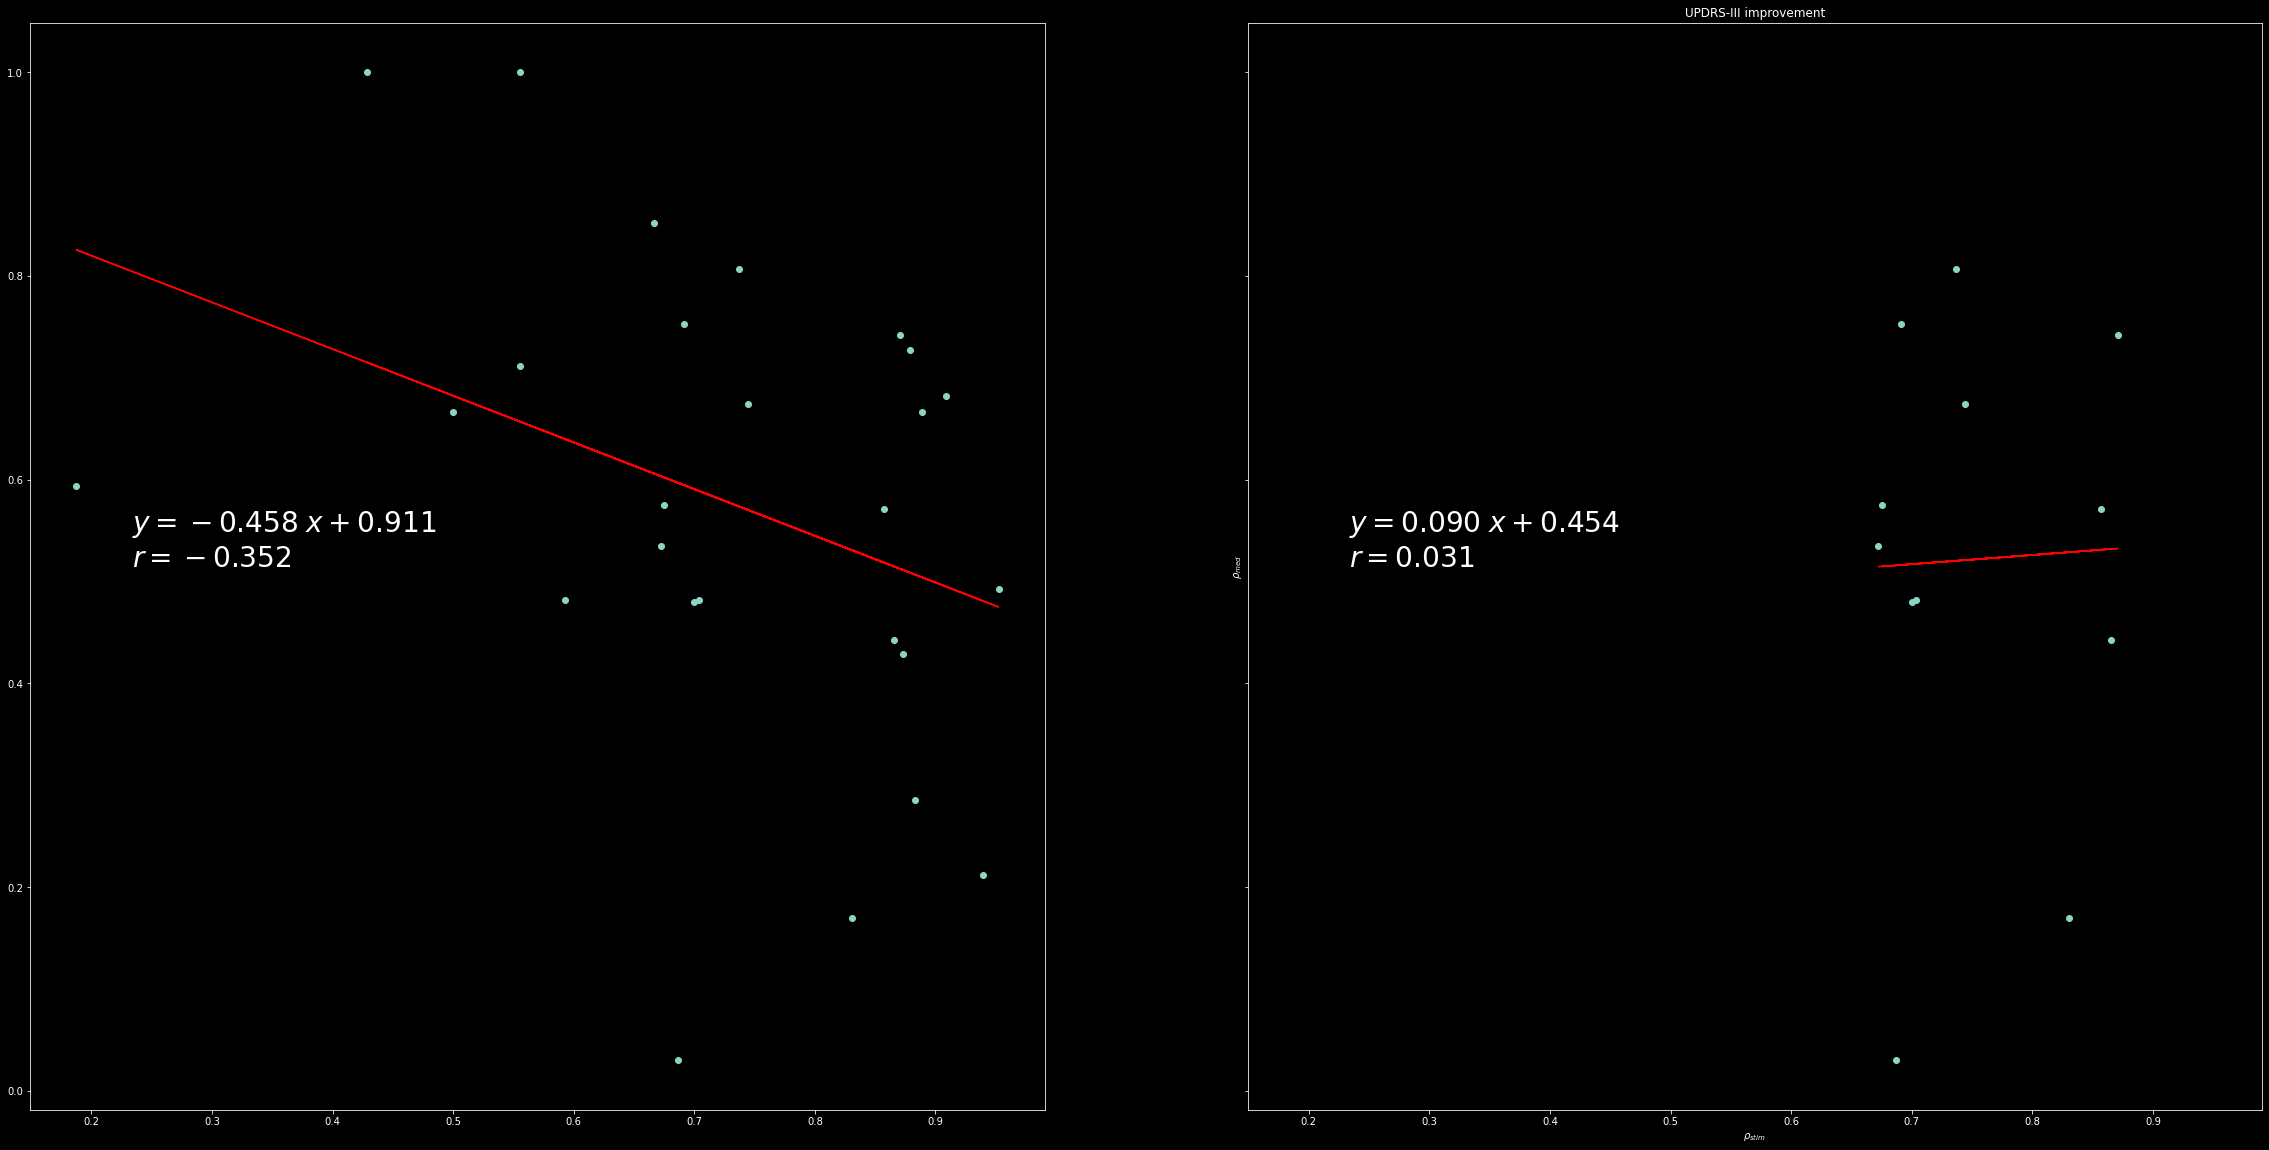

In [17]:
# Plot the data and fit like Zaidel et. al Figure 3C
[fig,(ax1,ax2)] = plt.subplots(1,2,sharex=True,sharey=True)
lr_rho_med = linregress(dbs_off_meds_improvement,pre_dbs_meds_improvement)
ax1.scatter(dbs_off_meds_improvement,pre_dbs_meds_improvement)
ax1.plot(dbs_off_meds_improvement,dbs_off_meds_improvement*lr_rho_med.slope+lr_rho_med.intercept,'-r')
text = f"$y={lr_rho_med.slope:0.3f}\;x{lr_rho_med.intercept:+0.3f}$\n$r = {lr_rho_med.rvalue:0.3f}$"
ax1.text(0.1, 0.5, text, transform=ax1.transAxes,fontsize=28)

x_m = iqr_exclude(dbs_off_meds_improvement)
dbs_off_meds_improvement = dbs_off_meds_improvement[x_m]
pre_dbs_meds_improvement = pre_dbs_meds_improvement[x_m]

lr_rho_med = linregress(dbs_off_meds_improvement,pre_dbs_meds_improvement)
ax2.scatter(dbs_off_meds_improvement,pre_dbs_meds_improvement)
ax2.plot(dbs_off_meds_improvement,dbs_off_meds_improvement*lr_rho_med.slope+lr_rho_med.intercept,'-r')
text = f"$y={lr_rho_med.slope:0.3f}\;x{lr_rho_med.intercept:+0.3f}$\n$r = {lr_rho_med.rvalue:0.3f}$"
ax2.text(0.1, 0.5, text, transform=ax2.transAxes,fontsize=28)

plt.rcParams["figure.figsize"] = (40,20)
plt.xlabel(r'$\rho_{stim}$')
plt.ylabel(r'$\rho_{med}$')
plt.title('UPDRS-III improvement')
plt.show;

In [18]:
x_m = iqr_exclude(dbs_off_meds_improvement)
dbs_off_meds_improvement = dbs_off_meds_improvement[x_m]
pre_dbs_meds_improvement = pre_dbs_meds_improvement[x_m]

75th percentile at 0.8373626373626374
25th percentile at 0.6901603095632947
Interquartile range of 0.14720232779934272
Upper bound of 0.9845649651619801
Lower bound of 0.5429579817639519
Excluded 6 outliers


In [19]:
motor_df['Anonymous ID'].to_numpy().astype('float')[cases][x_m]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 26 but corresponding boolean dimension is 12

In [ ]:
# Plot the data and fit like Zaidel et. al Figure 3C
lr_rho_med = linregress(dbs_off_meds_improvement,pre_dbs_meds_improvement)
plt.scatter(dbs_off_meds_improvement,pre_dbs_meds_improvement)
plt.plot(dbs_off_meds_improvement,dbs_off_meds_improvement*lr_rho_med.slope+lr_rho_med.intercept,'-r')
text = f"$y={lr_rho_med.slope:0.3f}\;x{lr_rho_med.intercept:+0.3f}$\n$r = {lr_rho_med.rvalue:0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.rcParams["figure.figsize"] = (20,20)
plt.xlabel(r'$\rho_{stim}$')
plt.ylabel(r'$\rho_{med}$')
plt.xlim([0.5,1])
plt.ylim([0,1])
plt.title('UPDRS-III improvement')
plt.show;

Lin et. al also defines a postoperative measure where all scores are collected after the DBS surgery:

$$ \rho_{post} = \frac{u_{post,\,off\,med,\,stim\,off}-u_{post,\,stim\,on,\,off\,med}}{u_{post,\,off\,med,\,stim\,off}}$$

Where $\rho_{post}$ is `postop_improvement`, $u_{post,\,off\,med,\,stim\,off}$ is `df_post_dbs_off_meds_off_stim` and $u_{post,\,on\,stim,\,off\,med}$ is `df_post_dbs_off_meds_on_stim`

The preoperative measure is equivalent to $\rho_{med}$.

In [ ]:
# Find cases that have preoperative and postoperative data
postop_cases = []
for ids in np.arange(0,df_post_dbs_off_meds_off_stim.__len__()):
    if ~np.isnan(df_post_dbs_off_meds_off_stim[ids]) and ~np.isnan(df_post_dbs_off_meds_on_stim[ids]): 
            postop_cases.append(ids)

postop_improvement = (df_post_dbs_off_meds_off_stim[postop_cases]-df_post_dbs_off_meds_on_stim[postop_cases])/df_post_dbs_off_meds_off_stim[postop_cases]
preop_improvement = (df_pre_dbs_off_meds[postop_cases]-df_pre_dbs_on_meds[postop_cases])/df_pre_dbs_off_meds[postop_cases]
lr_prepost = linregress(preop_improvement,postop_improvement)



In [ ]:
# Plot the data and fit like Lin et. al Figure 1B
plt.scatter(preop_improvement,postop_improvement)
plt.plot(dbs_off_meds_improvement,dbs_off_meds_improvement*lr_rho_med.slope+lr_rho_med.intercept,'-r')
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.rcParams["figure.figsize"] = (20,20)

plt.xlabel(r'$\rho_{med}$')
plt.ylabel(r'$\rho_{post}$')
plt.title('UPDRS-III improvement')
plt.show;

<b>References</b>
$$$$
A. Zaidel, H. Bergman, Y. Ritovand Z. I. Md, “Levodopa and subthalamic deep brain stimulation responses are not congruent”, Movement Disorders, vol. 25, no. 14, pp. 2379–2386, 2010, doi: 10.1002/mds.23294. 
$$$$
W. Zhao, “Relationship Between Iron Distribution in Deep Gray Matter Nuclei Measured by Quantitative Susceptibility Mapping and Motor Outcome After Deep Brain Stimulation in Patients With Parkinson's Disease”, Journal of Magnetic Resonance Imaging, 2023, doi: 10.1002/jmri.28574.
$$$$
Liu Y, Xiao B, Zhang C, et al. Predicting Motor Outcome of Subthalamic Nucleus Deep Brain Stimulation for Parkinson's Disease Using Quantitative Susceptibility Mapping and Radiomics: A Pilot Study. Front Neurosci. 2021;15:731109. Published 2021 Sep 7. doi:10.3389/fnins.2021.731109
$$$$
Lin Z, Zhang X, Wang L, Zhang Y, Zhou H, Sun Q, Sun B, Huang P, Li D. Revisiting the L-Dopa Response as a Predictor of Motor Outcomes After Deep Brain Stimulation in Parkinson's Disease. Front Hum Neurosci. 2021 Feb 4;15:604433. doi: 10.3389/fnhum.2021.604433. PMID: 33613209; PMCID: PMC7889513.